In [3]:
# Install this (run the cell):
# !apt-get install openjdk-8-jdk-headless -qq
# !pip install pyspark

First make sure of having a copy of the data in your own drive so, for example, "/content/drive/MyDrive/Google-Maps" path can work.

In [4]:
# Give access to your Drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
from pyspark.sql.functions import col, sum, count
from pyspark.sql.functions import input_file_name, regexp_extract
import matplotlib.pyplot as plt
import seaborn as sns
import re

# metadata-sitios
Observations:
- There are 3.025.011 rows and 15 columns.
- Number of nulls:
  - "MISC": 690.834
  - "address": 80.511
  - "category": 17.419
  - "description": 2.770.722
  - "hours": 787.405
  - "name": 37
  - "price": 2.749.808
  - "relative_results": 295.058
  - "state": 746.455
- Seems to be 26.573 duplicates

In [6]:
json_files = [
    '/content/drive/MyDrive/Google Maps/metadata-sitios/1.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/2.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/3.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/4.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/5.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/6.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/7.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/8.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/9.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/10.json',
    '/content/drive/MyDrive/Google Maps/metadata-sitios/11.json'
]

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the JSON files into Spark DataFrames
gmaps_metadata = spark.read.json(json_files)

In [7]:
# To get the shape (number of rows and columns) of the DataFrame:
rows, columns = (gmaps_metadata.count(), len(gmaps_metadata.columns))
f'There are {rows} rows and {columns} columns.'

'There are 3025011 rows and 15 columns.'

In [8]:
# View the first few rows of the DataFrame:
gmaps_metadata.show()

+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|                MISC|             address|avg_rating|            category|         description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|
+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+
|{[Wheelchair acce...|Porter Pharmacy, ...|       4.9|          [Pharmacy]|                null|0x88f16e41928ff68...|[[Friday, 8AM–6PM...|           32

In [9]:
# Retrieve the column names:
gmaps_metadata.columns


['MISC',
 'address',
 'avg_rating',
 'category',
 'description',
 'gmap_id',
 'hours',
 'latitude',
 'longitude',
 'name',
 'num_of_reviews',
 'price',
 'relative_results',
 'state',
 'url']

In [10]:
# To get information about the DataFrame, including column data types and null counts:
gmaps_metadata.printSchema()

root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Getting here: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health and safety: array (nullable = true)


## Null values analysis

In [11]:
# To count the number of null values in each column:
gmaps_metadata.select([sum(col(c).isNull().cast("int")).alias(c) for c in gmaps_metadata.columns]).show()

+------+-------+----------+--------+-----------+-------+------+--------+---------+----+--------------+-------+----------------+------+---+
|  MISC|address|avg_rating|category|description|gmap_id| hours|latitude|longitude|name|num_of_reviews|  price|relative_results| state|url|
+------+-------+----------+--------+-----------+-------+------+--------+---------+----+--------------+-------+----------------+------+---+
|690834|  80511|         0|   17419|    2770722|      0|787405|       0|        0|  37|             0|2749808|          295058|746455|  0|
+------+-------+----------+--------+-----------+-------+------+--------+---------+----+--------------+-------+----------------+------+---+



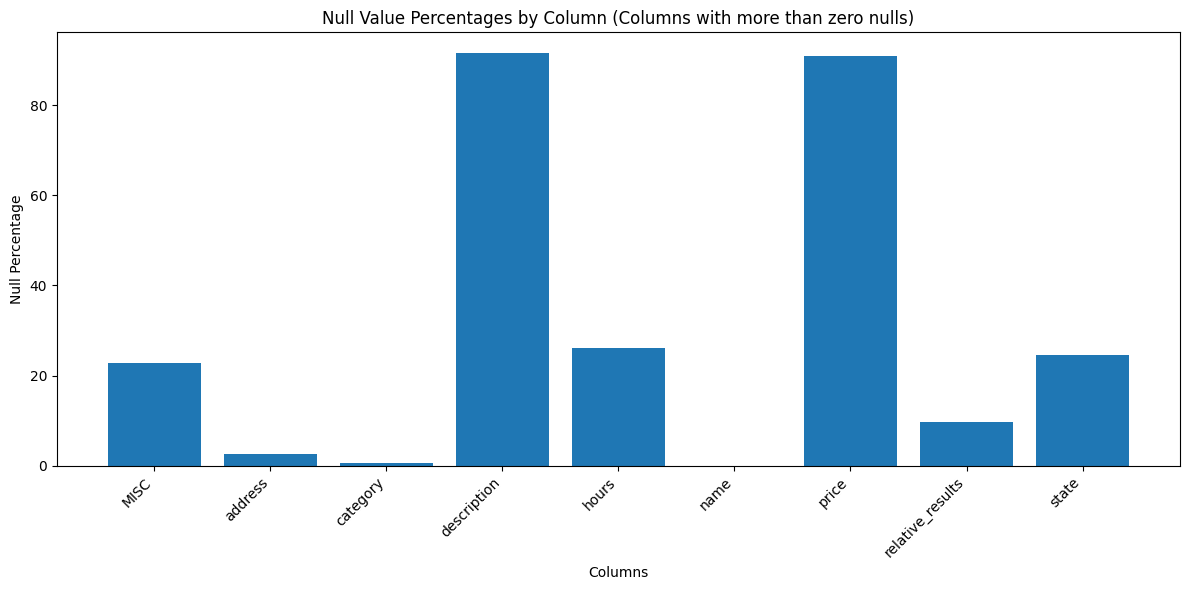

In [23]:
# Store the null value counts in a list
null_counts = gmaps_metadata.select([sum(col(c).isNull().cast("int")).alias(c) for c in gmaps_metadata.columns]).collect()[0]

# Get the column names
column_names = gmaps_metadata.columns

# Calculate the total number of rows
total_rows = gmaps_metadata.count()

# Calculate null percentages for columns with more than zero nulls
null_percentages = [(column_name, null_count/total_rows * 100) for column_name, null_count in zip(column_names, null_counts) if null_count > 0]

# Unzip the column names and percentages
column_names, percentages = zip(*null_percentages)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(column_names, percentages)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Null Percentage')
plt.title('Null Value Percentages by Column')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

In [12]:
# To count the number of duplicated rows in the DataFrame:
gmaps_metadata.groupBy(gmaps_metadata.columns).count().filter("count > 1").count()

26573

In [40]:
# Count the total number of duplicates taking "gmap_id" column
total_duplicates = gmaps_metadata.groupBy("gmap_id").count().filter(col("count") > 1).count()

# Print the total count of duplicates
print("Total duplicates: ", total_duplicates)

Total duplicates:  26573


## Outliers in number of reviews

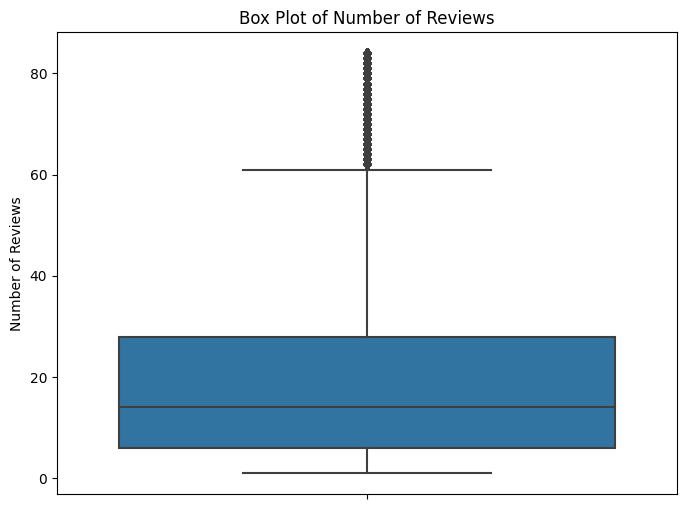

In [36]:
# Select the "num_of_reviews" column
num_of_reviews_col = "num_of_reviews"  # Replace with the actual column name for num_of_reviews

# Convert the column to numeric type
df = gmaps_metadata.withColumn(num_of_reviews_col, col(num_of_reviews_col).cast("double"))

# Calculate the quartiles and IQR for outlier detection
quartiles = df.approxQuantile(num_of_reviews_col, [0.25, 0.5, 0.75], 0.01)
q1 = quartiles[0]
q3 = quartiles[2]
iqr = q3 - q1

# Define the lower and upper bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter the DataFrame to keep rows within the bounds
filtered_df = df.filter((col(num_of_reviews_col) >= lower_bound) & (col(num_of_reviews_col) <= upper_bound))

# Convert the filtered DataFrame to Pandas for plotting
pandas_df = filtered_df.select(num_of_reviews_col).toPandas()

# Plot a box plot to visualize the distribution and outliers
plt.figure(figsize=(8, 6))
sns.boxplot(data=pandas_df, y=num_of_reviews_col)
plt.ylabel("Number of Reviews")
plt.title("Box Plot of Number of Reviews")
plt.show()

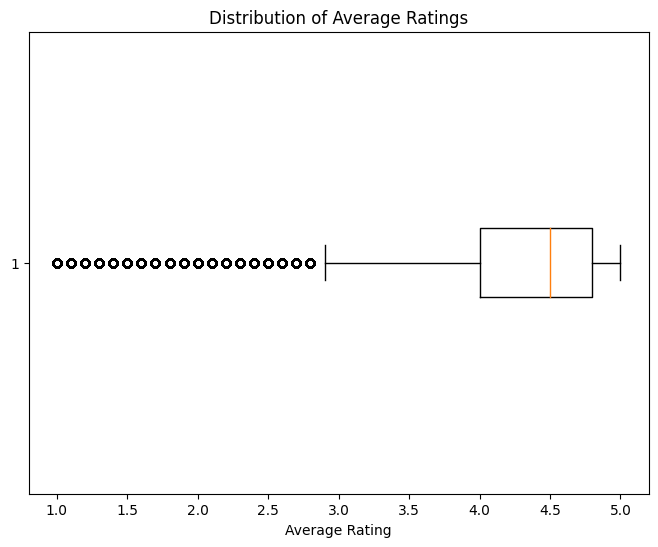

In [37]:
# Extract the "avg_rating" column from the Spark DataFrame
avg_ratings_data = gmaps_metadata.select("avg_rating").rdd.flatMap(lambda x: x).collect()

# Create the horizontal box plot
plt.figure(figsize=(8, 6))
plt.boxplot(avg_ratings_data, vert=False)

# Set labels and title
plt.xlabel("Average Rating")
plt.ylabel("")

plt.title("Distribution of Average Ratings")

# Show the plot
plt.show()

# reviews-estados
Observations:
- There are 89.946.359 rows and 9 columns.
- There are nulls in columns: 
  - "pics" (87.450.680)
  - "resp" (78.917.249)
  - "text" (39.307.744)
- Seems to be 1.386.843 duplicates

In [13]:
# Create a SparkSession
spark = SparkSession.builder.getOrCreate()
# Specify the parent directory containing state directories
parent_directory = '/content/drive/MyDrive/Google Maps/reviews-estados/'
# Read the JSON files into Spark DataFrames and extract state from directory structure
gmaps_reviews = spark.read.json(parent_directory + "*/*.json") \
    .withColumn("state", regexp_extract(input_file_name(), r".*/([^/]+)/[^/]+\.json", 1))

In [14]:
# Show the DataFrame
gmaps_reviews.show()

+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+-----------+
|             gmap_id|                name|pics|rating|                resp|                text|         time|             user_id|      state|
+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+-----------+
|0x87528767d0ec0e4...|          Liz W Poch|null|     5|                null|Paige is the best...|1627085008811|11118259507767436...|review-Utah|
|0x87528767d0ec0e4...|    Mario D'Ambrosio|null|     1|                null|I have updated my...|1626437133578|11768917084644824...|review-Utah|
|0x87528767d0ec0e4...|     Kathleen Hambly|null|     5|                null|Simone is the bes...|1585165423975|11583468565499948...|review-Utah|
|0x87528767d0ec0e4...|       Crystal Olsen|null|     1|                null|Ive called severa...|1591629458998|11267961121373171..

In [15]:
# Get the shape (number of rows and columns) of the DataFrame:
rows, columns = (gmaps_reviews.count(), len(gmaps_reviews.columns))
f'There are {rows} rows and {columns} columns.'

'There are 89946359 rows and 9 columns.'

In [16]:
# To get information about the DataFrame, including column data types and null counts:
gmaps_reviews.printSchema()

root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- state: string (nullable = false)



In [17]:
# To count the number of null values in each column:
gmaps_reviews.select([sum(col(c).isNull().cast("int")).alias(c) for c in gmaps_reviews.columns]).show()

+-------+----+--------+------+--------+--------+----+-------+-----+
|gmap_id|name|    pics|rating|    resp|    text|time|user_id|state|
+-------+----+--------+------+--------+--------+----+-------+-----+
|      0|   0|87450680|     0|78917249|39307744|   0|      0|    0|
+-------+----+--------+------+--------+--------+----+-------+-----+



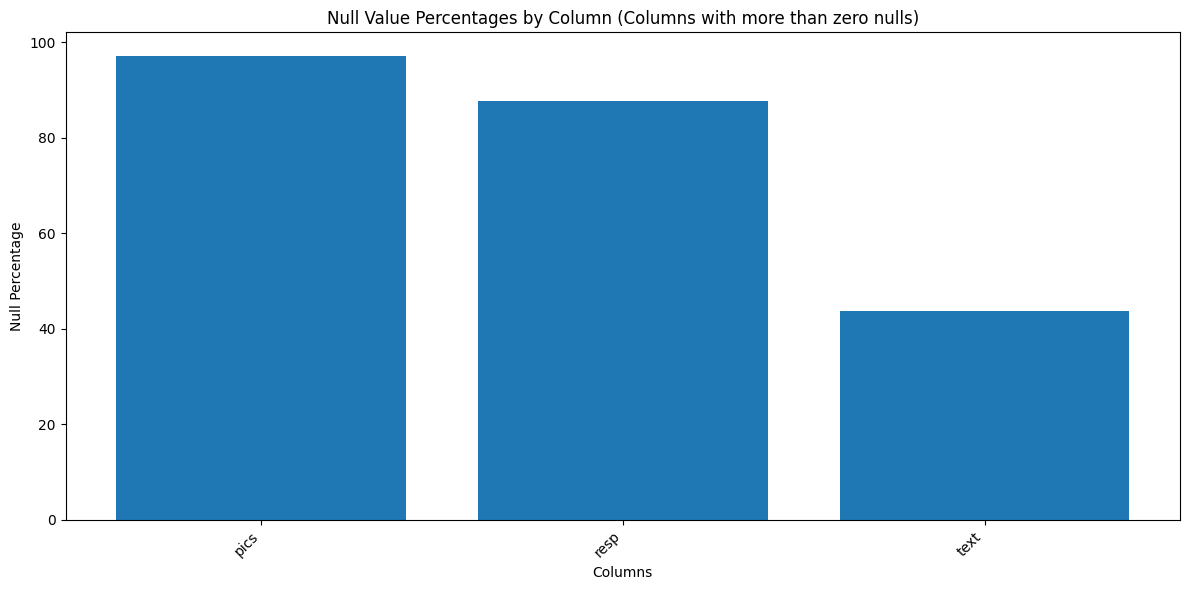

In [24]:
# Store the null value counts in a list
null_counts = gmaps_reviews.select([sum(col(c).isNull().cast("int")).alias(c) for c in gmaps_reviews.columns]).collect()[0]

# Get the column names
column_names = gmaps_reviews.columns

# Calculate the total number of rows
total_rows = gmaps_reviews.count()

# Calculate null percentages for columns with more than zero nulls
null_percentages = [(column_name, null_count/total_rows * 100) for column_name, null_count in zip(column_names, null_counts) if null_count > 0]

# Unzip the column names and percentages
column_names, percentages = zip(*null_percentages)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(column_names, percentages)

# Add labels and title
plt.xlabel('Columns')
plt.ylabel('Null Percentage')
plt.title('Null Value Percentages by Column (Columns with more than zero nulls)')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

In [18]:
# To count the number of duplicated rows in the DataFrame:
gmaps_reviews.groupBy(gmaps_reviews.columns).count().filter("count > 1").count()

1386843

In [19]:
numerical_cols = ['rating']
gmaps_reviews.select(numerical_cols).describe().show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|          89946359|
|   mean|4.3019362128932865|
| stddev|1.1007920513773455|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [34]:
def check_coordinate_inconsistencies(df):
    latitude_col = "latitude"  # Replace with the actual column name for latitude
    longitude_col = "longitude"  # Replace with the actual column name for longitude

    invalid_coordinates = df.filter(
        (col(latitude_col) < -90) | (col(latitude_col) > 90) |
        (col(longitude_col) < -180) | (col(longitude_col) > 180)
    )

    invalid_coordinates.show()

check_coordinate_inconsistencies(gmaps_metadata)

+----+-------+----------+--------+-----------+-------+-----+--------+---------+----+--------------+-----+----------------+-----+---+
|MISC|address|avg_rating|category|description|gmap_id|hours|latitude|longitude|name|num_of_reviews|price|relative_results|state|url|
+----+-------+----------+--------+-----------+-------+-----+--------+---------+----+--------------+-----+----------------+-----+---+
+----+-------+----------+--------+-----------+-------+-----+--------+---------+----+--------------+-----+----------------+-----+---+

